# Load point clouds, features, and coarse transformation

In [1]:
import numpy as np

# Cached results
fixed_pts_path = 'fixed_pts.npy'
moving_pts_path = 'moving_pts.npy'
fixed_features_path = 'fixed_features.npy'
moving_features_path = 'moving_features.npy'

In [2]:
fixed_pts = np.load(fixed_pts_path)
moving_pts = np.load(moving_pts_path)
fixed_feat = np.load(fixed_features_path)
moving_feat = np.load(moving_features_path)

print('keypoints:', fixed_pts.shape, moving_pts.shape)
print('features:', fixed_feat.shape, moving_feat.shape)

keypoints: (2321188, 3) (2963783, 3)
features: (2321188, 6) (2963783, 6)


In [3]:
import pickle

def open_dict(filename):
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [4]:
transformation_dict = open_dict('transformation.pkl')

t = transformation_dict['t']
center = transformation_dict['center']
theta = transformation_dict['theta']

print("Translation (px):", t)
print("Rotation center (px):", center)
print("Anlges (rad):", theta)

Translation (px): [311.16100834 344.52782833  34.03806768]
Rotation center (px): [1733.96332053 3756.18215795 2641.98084936]
Anlges (rad): [ 2.98451706 -3.14159265  3.1384992 ]


In [5]:
from phathom.registration import pcloud, coarse
from functools import partial

/home/jswaney/anaconda3/envs/phathom/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
r = pcloud.rotation_matrix(theta)
transformation = partial(coarse.rigid_transformation, 
                         t=t, 
                         r=r, 
                         center=center)

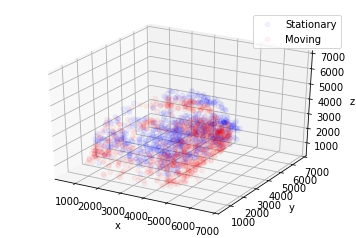

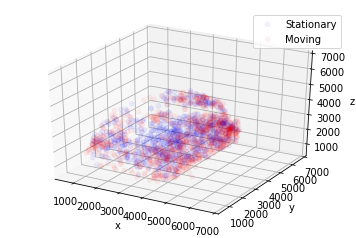

In [7]:
%matplotlib inline
from phathom import plotting

nb_pts = 1000

transformed_pts = transformation(pts=fixed_pts)

transformed_idx = np.random.choice(np.arange(fixed_pts.shape[0]), nb_pts)
moving_idx = np.random.choice(np.arange(moving_pts.shape[0]), nb_pts)

plotting.plot_pts(moving_pts[moving_idx], 
                  fixed_pts[transformed_idx], 
                  alpha=0.05)

plotting.plot_pts(moving_pts[moving_idx], 
                  transformed_pts[transformed_idx], 
                  alpha=0.05)

# Load matching indices

In [8]:
idx_fixed_path = 'idx_fixed2.npy'
idx_moving_path = 'idx_moving2.npy'

idx_fixed = np.load(idx_fixed_path)
idx_moving = np.load(idx_moving_path)

print('# matches loaded:', idx_fixed.shape[0])

# matches loaded: 1413


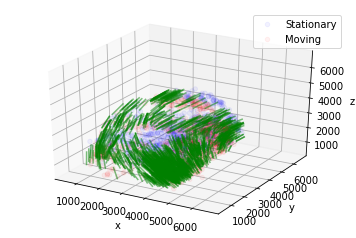

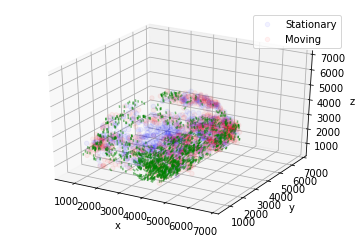

In [9]:
# %matplotlib notebook
from phathom import plotting

nb_pts = 1000

transformed_pts = transformation(pts=fixed_pts)

transformed_idx = np.random.choice(np.arange(fixed_pts.shape[0]), nb_pts)
moving_idx = np.random.choice(np.arange(moving_pts.shape[0]), nb_pts)

plotting.plot_pts(moving_pts[moving_idx], 
                  fixed_pts[transformed_idx],
                  0.05,
                  moving_pts[idx_moving],
                  fixed_pts[idx_fixed])

plotting.plot_pts(moving_pts[moving_idx], 
                  transformed_pts[transformed_idx], 
                  0.05,
                  moving_pts[idx_moving],
                  transformed_pts[idx_fixed])

# Filter out incoherent displacements

In [10]:
voxel_dimensions = (2.0, 1.6, 1.6)

fixed_keypoints_um = fixed_pts[idx_fixed] * np.asarray(voxel_dimensions)
moving_keypoints_um = moving_pts[idx_moving] * np.asarray(voxel_dimensions)

Average coherence: 0.9993790605217762
Found 3 outliers


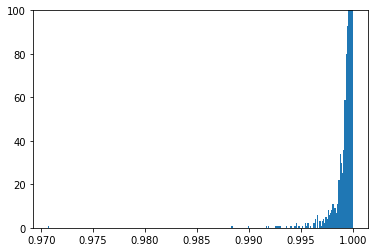

In [11]:
from sklearn.neighbors import NearestNeighbors
from scipy import spatial
import matplotlib.pyplot as plt

n_neighbors = 3
min_similarity = 0.99

nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='kd_tree', n_jobs=-1)
nbrs.fit(fixed_keypoints_um)
distances, indices = nbrs.kneighbors(fixed_keypoints_um)

cosine_similarity = np.zeros((idx_fixed.shape[0], n_neighbors))
for i, idxs in enumerate(indices):
    displacement = moving_keypoints_um[i] - fixed_keypoints_um[i]
    
    neighbor_idxs = idxs[1:]
    fixed_neighbors = fixed_keypoints_um[neighbor_idxs]
    moving_neighbors = moving_keypoints_um[neighbor_idxs]
    displacement_neighbors = moving_neighbors - fixed_neighbors
    
    for j, d in enumerate(displacement_neighbors):
        cosine_similarity[i, j] = 1-spatial.distance.cosine(displacement, d)

coherence = cosine_similarity.mean(axis=-1)

inlier_idx = np.where(coherence > min_similarity)
outlier_idx = np.where(coherence <= min_similarity)

fixed_keypoints_um = fixed_keypoints_um[inlier_idx]
moving_keypoints_um = moving_keypoints_um[inlier_idx]

print('Average coherence: {}'.format(coherence.mean()))
print('Found {} outliers'.format(len(coherence)-len(inlier_idx[0])))
        
plt.hist(cosine_similarity.mean(axis=-1), bins=256)
plt.ylim([0, 100])
plt.show()

# Affine registration

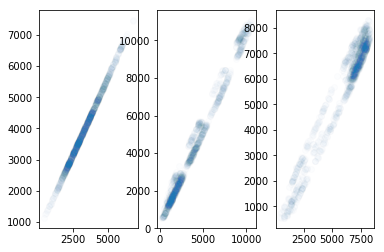

In [12]:
alpha = 0.01

for i in range(fixed_keypoints_um.ndim+1):
    plt.subplot(1,3,i+1)
    plt.scatter(fixed_keypoints_um[:, i], 
                moving_keypoints_um[:, i], 
                alpha=alpha)
plt.show()

In [13]:
resid_thresh = None
min_samples = 20

ransac, ransac_inliers = pcloud.estimate_affine(fixed_pts[idx_fixed[inlier_idx]],
                                                moving_pts[idx_moving[inlier_idx]],
                                                min_samples=min_samples,
                                                residual_threshold=resid_thresh)

In [14]:
affine_keypoints = pcloud.register_pts(fixed_pts[idx_fixed[inlier_idx]], ransac)

affine_keypoints_um = affine_keypoints * np.asarray(voxel_dimensions)

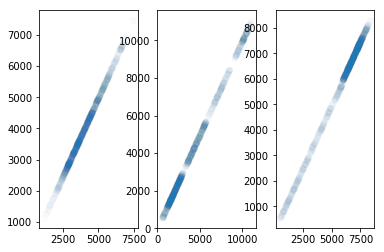

In [15]:
for i in range(fixed_keypoints_um.ndim+1):
    plt.subplot(1,3,i+1)
    plt.scatter(affine_keypoints_um[:, i], 
                moving_keypoints_um[:, i], 
                alpha=alpha)
plt.show()

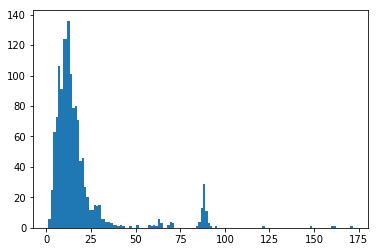

18.196354068846038


In [16]:
nonrigid_residuals = np.linalg.norm(affine_keypoints_um-moving_keypoints_um,
                                    axis=-1)

plt.hist(nonrigid_residuals, bins=128)
plt.show()

ave_resid_nonrigid = np.mean(nonrigid_residuals)
print(ave_resid_nonrigid)

# Distance filtering

In [17]:
max_distance = 50

distance_inlier_idx = np.where(nonrigid_residuals < max_distance)

In [18]:
fixed_keypoints_dist = fixed_pts[idx_fixed[inlier_idx]][distance_inlier_idx]
moving_keypoints_dist = moving_pts[idx_moving[inlier_idx]][distance_inlier_idx]

fixed_keypoints_dist_um = fixed_keypoints_dist * np.asarray(voxel_dimensions)
moving_keypoints_dist_um = moving_keypoints_dist * np.asarray(voxel_dimensions)

In [19]:
ransac, ransac_inliers = pcloud.estimate_affine(fixed_keypoints_dist,
                                                moving_keypoints_dist,
                                                min_samples=min_samples,
                                                residual_threshold=resid_thresh)

In [20]:
affine_keypoints_dist = pcloud.register_pts(fixed_keypoints_dist, ransac)

affine_keypoints_dist_um = affine_keypoints_dist * np.asarray(voxel_dimensions)

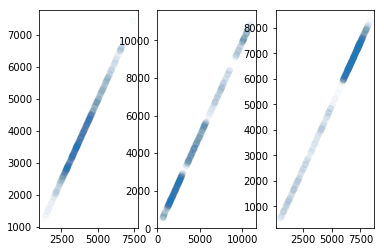

In [21]:
for i in range(fixed_keypoints_dist_um.ndim+1):
    plt.subplot(1,3,i+1)
    plt.scatter(affine_keypoints_dist_um[:, i], 
                moving_keypoints_dist_um[:, i], 
                alpha=alpha)
plt.show()

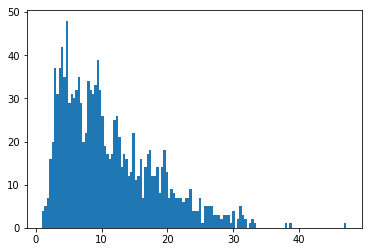

11.178695165941805


In [22]:
nonrigid_residuals = np.linalg.norm(affine_keypoints_dist_um-moving_keypoints_dist_um,
                                    axis=-1)

plt.hist(nonrigid_residuals, bins=128)
plt.show()

ave_resid_nonrigid = np.mean(nonrigid_residuals)
print(ave_resid_nonrigid)

# Sklearn affine model

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

degree = 1

def fit_polynomial_transform(fixed_keypts, moving_keypts, degree):
    fixed_poly = PolynomialFeatures(degree=degree).fit_transform(fixed_keypts)
    model_z = LinearRegression(fit_intercept=False).fit(fixed_poly, 
                                                        moving_keypts[:, 0])
    model_y = LinearRegression(fit_intercept=False).fit(fixed_poly, 
                                                        moving_keypts[:, 1])
    model_x = LinearRegression(fit_intercept=False).fit(fixed_poly, 
                                                        moving_keypts[:, 2])
    return model_z, model_y, model_x

def polynomial_transform(pts, degree, model_z, model_y, model_x):
    poly = PolynomialFeatures(degree=degree).fit_transform(pts)
    transformed_keypts = np.empty_like(pts)
    transformed_keypts[:, 0] = model_z.predict(poly)
    transformed_keypts[:, 1] = model_y.predict(poly)
    transformed_keypts[:, 2] = model_x.predict(poly)
    return transformed_keypts

model_z, model_y, model_x = fit_polynomial_transform(fixed_keypoints_dist, 
                                                     moving_keypoints_dist, 
                                                     degree)
affine_transformation = partial(polynomial_transform, 
                                  degree=degree,
                                  model_z=model_z, 
                                  model_y=model_y,
                                  model_x=model_x)

# Build non-rigid transformation (RBF version)

In [24]:
from scipy.interpolate import Rbf

In [96]:
nb_samples = affine_keypoints_dist.shape[0]

sample_idx = np.random.choice(np.arange(affine_keypoints_dist.shape[0]), 
                              nb_samples,
                              replace=False)

In [97]:
smooth = 1

rbf_z = Rbf(affine_keypoints_dist[sample_idx, 0],
            affine_keypoints_dist[sample_idx, 1],
            affine_keypoints_dist[sample_idx, 2],
            moving_keypoints_dist[sample_idx, 0],
            smooth=smooth,
            function='thin_plate')

rbf_y = Rbf(affine_keypoints_dist[sample_idx, 0],
            affine_keypoints_dist[sample_idx, 1],
            affine_keypoints_dist[sample_idx, 2],
            moving_keypoints_dist[sample_idx, 1],
            smooth=smooth,
            function='thin_plate')

rbf_x = Rbf(affine_keypoints_dist[sample_idx, 0],
            affine_keypoints_dist[sample_idx, 1],
            affine_keypoints_dist[sample_idx, 2],
            moving_keypoints_dist[sample_idx, 2],
            smooth=smooth,
            function='thin_plate')

In [98]:
zi = rbf_z(affine_keypoints_dist[:, 0],
           affine_keypoints_dist[:, 1],
           affine_keypoints_dist[:, 2])

yi = rbf_y(affine_keypoints_dist[:, 0],
           affine_keypoints_dist[:, 1],
           affine_keypoints_dist[:, 2])

xi = rbf_x(affine_keypoints_dist[:, 0],
           affine_keypoints_dist[:, 1],
           affine_keypoints_dist[:, 2])

nonrigid_keypoints_dist = np.column_stack([zi, yi, xi])
nonrigid_keypoints_dist_um = nonrigid_keypoints_dist * np.asarray(voxel_dimensions)

In [99]:
for i in range(nonrigid_keypoints_dist_um.ndim+1):
    plt.subplot(1,3,i+1)
    plt.scatter(nonrigid_keypoints_dist_um[:, i], 
                moving_keypoints_dist_um[:, i], 
                alpha=alpha)
plt.show()

<IPython.core.display.Javascript object>


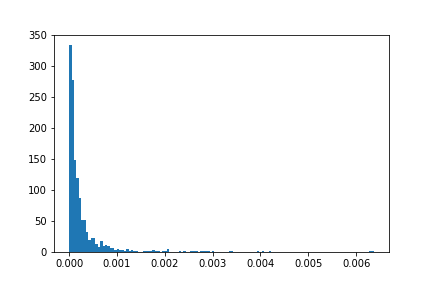

0.00027075594476862826


In [100]:
nonrigid_residuals = np.linalg.norm(nonrigid_keypoints_dist_um-moving_keypoints_dist_um,
                                    axis=-1)

plt.hist(nonrigid_residuals, bins=128)
plt.show()

ave_resid_nonrigid = np.mean(nonrigid_residuals)
print(ave_resid_nonrigid)

In [101]:
def nonrigid_transform(pts):
    affine_pts = affine_transformation(pts)
    zi = rbf_z(affine_pts[:, 0], affine_pts[:, 1], affine_pts[:, 2])
    yi = rbf_y(affine_pts[:, 0], affine_pts[:, 1], affine_pts[:, 2])
    xi = rbf_x(affine_pts[:, 0], affine_pts[:, 1], affine_pts[:, 2])
    return np.column_stack([zi, yi, xi])

# Build non-rigid transformation (MBA version)

In [31]:
from phathom import io
from mba import mba3

In [32]:
fixed_zarr_path = 'fixed.zarr'

fixed_img = io.zarr.open(fixed_zarr_path)

In [33]:
cmin = np.zeros(3)
cmax = np.array(fixed_img.shape)
coo = affine_keypoints_dist.copy()  # affine(fixed_keypoints_dist)
val_z = moving_keypoints_dist[:, 0].copy()
val_y = moving_keypoints_dist[:, 1].copy()
val_x = moving_keypoints_dist[:, 2].copy()

In [77]:
m0 = 8
max_levels = 6

interp_z = mba3(cmin, cmax, [m0, m0, m0], coo, val_z, max_levels)
interp_y = mba3(cmin, cmax, [m0, m0, m0], coo, val_y, max_levels)
interp_x = mba3(cmin, cmax, [m0, m0, m0], coo, val_x, max_levels)

In [78]:
pred_z = interp_z(affine_keypoints_dist.copy())
pred_y = interp_y(affine_keypoints_dist.copy())
pred_x = interp_x(affine_keypoints_dist.copy())

nonrigid_keypoints_dist = np.column_stack([pred_z, pred_y, pred_x])

print(nonrigid_keypoints_dist)

[[ 642.         1402.         3027.        ]
 [ 845.94125599 2924.03684437  731.01584725]
 [ 840.99752162 2928.00858317  682.98773   ]
 ...
 [3435.00000001 6278.         1657.        ]
 [3733.72477232 4832.76406434 2173.93830058]
 [3727.55360144 4784.39954922 2173.1779639 ]]


In [79]:
residuals = np.linalg.norm(nonrigid_keypoints_dist - moving_keypoints_dist, axis=-1)

finite_idx = np.where(residuals < np.inf)[0]

finite_resid = np.linalg.norm(nonrigid_keypoints_dist[finite_idx] - moving_keypoints_dist[finite_idx], axis=-1)

print(len(finite_idx))
print(residuals.max())

1316
11.855986254543776


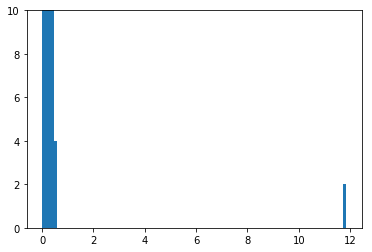

In [80]:
plt.hist(finite_resid, bins=100)
plt.ylim([0, 10])
plt.show()

In [81]:
def nonrigid_transform(pts):
    affine_pts = affine_transformation(pts)
    affine_pts = affine_pts.copy()
    zi = interp_z(affine_pts)
    yi = interp_y(affine_pts)
    xi = interp_x(affine_pts)
    return np.column_stack([zi, yi, xi])

# Apply non-rigid transformation

In [83]:
from phathom.registration import registration
from phathom import io
import zarr
from numcodecs import Blosc

In [84]:
moving_zarr_path = 'moving.zarr'

moving_img = io.zarr.open(moving_zarr_path)

In [85]:
fixed_zarr_path = 'fixed.zarr'

fixed_img = io.zarr.open(fixed_zarr_path)

In [153]:
grid_pts = 50

z = np.linspace(0, fixed_img.shape[0], grid_pts)
y = np.linspace(0, fixed_img.shape[1], grid_pts)
x = np.linspace(0, fixed_img.shape[2], grid_pts)

Z, Y, X = np.meshgrid(z, y, x, indexing='ij')
grid = np.column_stack([Z.ravel(), Y.ravel(), X.ravel()])
values = nonrigid_transform(grid)

grid_shape = values.shape[-1]*(grid_pts,)
values_z = np.reshape(values[:, 0], grid_shape)
values_y = np.reshape(values[:, 1], grid_shape)
values_x = np.reshape(values[:, 2], grid_shape)

values_y.shape

(50, 50, 50)

In [149]:
from scipy.interpolate import RegularGridInterpolator

In [154]:
interp_z = RegularGridInterpolator((z, y, x), values_z)
interp_y = RegularGridInterpolator((z, y, x), values_y)
interp_x = RegularGridInterpolator((z, y, x), values_x)

In [155]:
def interpolator(pts):
    values_z = interp_z(pts)
    values_y = interp_y(pts)
    values_x = interp_x(pts)
    return np.column_stack([values_z, values_y, values_x])

In [156]:
predicted = interpolator(fixed_keypoints_dist)

ave_resid = np.linalg.norm(predicted-moving_keypoints_dist, axis=-1).mean()
print(ave_resid)

0.33900788742799126


In [157]:
registered_img = registration.register_slice(moving_img,
                                             zslice=1000,
                                             output_shape=fixed_img.shape[1:],
                                             transformation=interpolator,
                                             batch_size=10000,
                                             padding=4)

100%|██████████| 4021/4021 [00:24<00:00, 162.06it/s]


In [88]:
fixed_slice = fixed_img[1000]

<IPython.core.display.Javascript object>


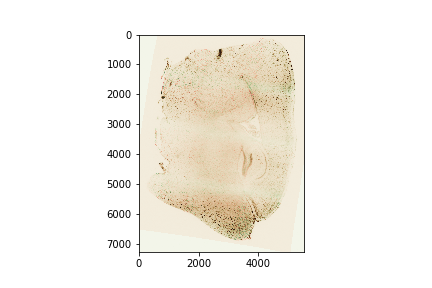

In [158]:
%matplotlib notebook
# plt.figure(figsize=(12, 6))
plt.imshow(registered_img, cmap='Reds', clim=[0, 1000])
plt.imshow(fixed_slice, cmap='Greens', alpha=0.5, clim=[0, 1000])
plt.show()

In [159]:
from skimage.external import tifffile

tifffile.imsave('fixed_slice.tif', fixed_slice)
tifffile.imsave('registered_slice.tif', registered_img)

In [34]:
nb_workers = 2
batch_size = None
output_zarr_path = 'nonrigid.zarr'

nonrigid_img = zarr.open(output_zarr_path,
                         mode='w',
                         shape=fixed_img.shape,
                         chunks=fixed_img.chunks,
                         dtype=fixed_img.dtype,
                         compressor=Blosc(cname='zstd', 
                                          clevel=1, 
                                          shuffle=Blosc.BITSHUFFLE))



# registration.register(moving_img, 
#                       fixed_img, 
#                       nonrigid_img, 
#                       nonrigid_transform, 
#                       nb_workers, 
#                       batch_size)

In [35]:
padding = 4

start_coords = registration.chunk_coordinates(fixed_img.shape, fixed_img.chunks)
args_list = []
for i, start_coord in enumerate(start_coords):
    start = np.asarray(start_coord)
    args = (moving_img, 
            nonrigid_img.chunks, 
            nonrigid_img,
            transformation,
#             nonrigid_transform, 
            start, 
            batch_size, 
            padding)
    args_list.append(args)

In [ ]:
registration.register(moving_img, 
         nonrigid_img, 
         transformation, 
         nb_workers, 
         batch_size=None, 
         padding=padding)

In [ ]:
registration.register_chunk(*args_list[0])

In [ ]:
for args in args_list:
    registration.register_chunk(*args)

# Register a single chunk

In [ ]:
import numpy as np
from phathom.registration.registration import *

# Cached results
fixed_pts_path = '/media/jswaney/Drive/Justin/coregistration/whole_brain/fixed_pts.npy'
moving_pts_path = '/media/jswaney/Drive/Justin/coregistration/whole_brain/moving_pts.npy'
fixed_features_path = '/media/jswaney/Drive/Justin/coregistration/whole_brain/fixed_features.npy'
moving_features_path = '/media/jswaney/Drive/Justin/coregistration/whole_brain/moving_features.npy'

fixed_pts = np.load(fixed_pts_path)
moving_pts = np.load(moving_pts_path)
fixed_feat = np.load(fixed_features_path)
moving_feat = np.load(moving_features_path)
print('keypoints:', fixed_pts.shape, moving_pts.shape)
print('features:', fixed_feat.shape, moving_feat.shape)


import pickle


def open_dict(filename):
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data


transformation_dict = open_dict('/media/jswaney/Drive/Justin/coregistration/whole_brain/transformation.pkl')

t = transformation_dict['t']
center = transformation_dict['center']
theta = transformation_dict['theta']

print("Translation (px):", t)
print("Rotation center (px):", center)
print("Anlges (rad):", theta)


from phathom.registration import pcloud, coarse
from functools import partial

r = pcloud.rotation_matrix(theta)
transformation = partial(coarse.rigid_transformation,
                         t=t,
                         r=r,
                         center=center)

nb_pts = 1000

transformed_pts = transformation(pts=fixed_pts)
transformed_idx = np.random.choice(np.arange(fixed_pts.shape[0]), nb_pts)
moving_idx = np.random.choice(np.arange(moving_pts.shape[0]), nb_pts)

idx_fixed_path = '/media/jswaney/Drive/Justin/coregistration/whole_brain/idx_fixed2.npy'
idx_moving_path = '/media/jswaney/Drive/Justin/coregistration/whole_brain/idx_moving2.npy'

idx_fixed = np.load(idx_fixed_path)
idx_moving = np.load(idx_moving_path)
print('# matches loaded:', idx_fixed.shape[0])

nb_pts = 1000

transformed_pts = transformation(pts=fixed_pts)
transformed_idx = np.random.choice(np.arange(fixed_pts.shape[0]), nb_pts)
moving_idx = np.random.choice(np.arange(moving_pts.shape[0]), nb_pts)

voxel_dimensions = (2.0, 1.6, 1.6)

fixed_keypoints_um = fixed_pts[idx_fixed] * np.asarray(voxel_dimensions)
moving_keypoints_um = moving_pts[idx_moving] * np.asarray(voxel_dimensions)

from sklearn.neighbors import NearestNeighbors
from scipy import spatial

n_neighbors = 3
min_similarity = 0.99

nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm='kd_tree', n_jobs=-1)
nbrs.fit(fixed_keypoints_um)
distances, indices = nbrs.kneighbors(fixed_keypoints_um)

cosine_similarity = np.zeros((idx_fixed.shape[0], n_neighbors))
for i, idxs in enumerate(indices):
    displacement = moving_keypoints_um[i] - fixed_keypoints_um[i]

    neighbor_idxs = idxs[1:]
    fixed_neighbors = fixed_keypoints_um[neighbor_idxs]
    moving_neighbors = moving_keypoints_um[neighbor_idxs]
    displacement_neighbors = moving_neighbors - fixed_neighbors

    for j, d in enumerate(displacement_neighbors):
        cosine_similarity[i, j] = 1 - spatial.distance.cosine(displacement, d)

coherence = cosine_similarity.mean(axis=-1)

inlier_idx = np.where(coherence > min_similarity)
outlier_idx = np.where(coherence <= min_similarity)

fixed_keypoints_um = fixed_keypoints_um[inlier_idx]
moving_keypoints_um = moving_keypoints_um[inlier_idx]

print('Average coherence: {}'.format(coherence.mean()))
print('Found {} outliers'.format(len(coherence) - len(inlier_idx[0])))

resid_thresh = None
min_samples = 20

ransac, ransac_inliers = pcloud.estimate_affine(fixed_pts[idx_fixed[inlier_idx]],
                                                moving_pts[idx_moving[inlier_idx]],
                                                min_samples=min_samples,
                                                residual_threshold=resid_thresh)


affine_keypoints = pcloud.register_pts(fixed_pts[idx_fixed[inlier_idx]], ransac)
affine_keypoints_um = affine_keypoints * np.asarray(voxel_dimensions)

nonrigid_residuals = np.linalg.norm(affine_keypoints_um-moving_keypoints_um,
                                    axis=-1)
ave_resid_nonrigid = np.mean(nonrigid_residuals)
print(ave_resid_nonrigid)

max_distance = 50

distance_inlier_idx = np.where(nonrigid_residuals < max_distance)
fixed_keypoints_dist = fixed_pts[idx_fixed[inlier_idx]][distance_inlier_idx]
moving_keypoints_dist = moving_pts[idx_moving[inlier_idx]][distance_inlier_idx]
fixed_keypoints_dist_um = fixed_keypoints_dist * np.asarray(voxel_dimensions)
moving_keypoints_dist_um = moving_keypoints_dist * np.asarray(voxel_dimensions)

ransac, ransac_inliers = pcloud.estimate_affine(fixed_keypoints_dist,
                                                moving_keypoints_dist,
                                                min_samples=min_samples,
                                                residual_threshold=resid_thresh)

affine_keypoints_dist = pcloud.register_pts(fixed_keypoints_dist, ransac)
affine_keypoints_dist_um = affine_keypoints_dist * np.asarray(voxel_dimensions)

# sklearn uses threading
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


degree = 1


def fit_polynomial_transform(fixed_keypts, moving_keypts, degree):
    fixed_poly = PolynomialFeatures(degree=degree).fit_transform(fixed_keypts)
    model_z = LinearRegression(fit_intercept=False).fit(fixed_poly,
                                                        moving_keypts[:, 0])
    model_y = LinearRegression(fit_intercept=False).fit(fixed_poly,
                                                        moving_keypts[:, 1])
    model_x = LinearRegression(fit_intercept=False).fit(fixed_poly,
                                                        moving_keypts[:, 2])
    return model_z, model_y, model_x


def polynomial_transform(pts, degree, model_z, model_y, model_x):
    poly = PolynomialFeatures(degree=degree).fit_transform(pts)
    transformed_keypts = np.empty_like(pts)
    transformed_keypts[:, 0] = model_z.predict(poly)
    transformed_keypts[:, 1] = model_y.predict(poly)
    transformed_keypts[:, 2] = model_x.predict(poly)
    return transformed_keypts


model_z, model_y, model_x = fit_polynomial_transform(fixed_keypoints_dist,
                                                     moving_keypoints_dist,
                                                     degree)

affine_transformation = partial(polynomial_transform,
                                  degree=degree,
                                  model_z=model_z,
                                  model_y=model_y,
                                  model_x=model_x)

from phathom import io
from mba import mba3


fixed_zarr_path = '/media/jswaney/Drive/Justin/coregistration/whole_brain/fixed.zarr'

fixed_img = io.zarr.open(fixed_zarr_path)

cmin = np.zeros(3)
cmax = np.array(fixed_img.shape)
coo = affine_keypoints_dist.copy()  # affine(fixed_keypoints_dist)
val_z = moving_keypoints_dist[:, 0].copy()
val_y = moving_keypoints_dist[:, 1].copy()
val_x = moving_keypoints_dist[:, 2].copy()

m0 = 3

interp_z = mba3(cmin, cmax, [m0, m0, m0], coo, val_z)
interp_y = mba3(cmin, cmax, [m0, m0, m0], coo, val_y)
interp_x = mba3(cmin, cmax, [m0, m0, m0], coo, val_x)

pred_z = interp_z(affine_keypoints_dist.copy())
pred_y = interp_y(affine_keypoints_dist.copy())
pred_x = interp_x(affine_keypoints_dist.copy())

nonrigid_keypoints_dist = np.column_stack([pred_z, pred_y, pred_x])


def nonrigid_transform(pts):
    affine_pts = affine_transformation(pts)
    affine_pts = affine_pts.copy()
    zi = interp_z(affine_pts)
    yi = interp_y(affine_pts)
    xi = interp_x(affine_pts)
    return np.column_stack([zi, yi, xi])


import zarr
import numcodecs
from numcodecs import Blosc


moving_zarr_path = '/media/jswaney/Drive/Justin/coregistration/whole_brain/moving.zarr'

moving_img = io.zarr.open(moving_zarr_path)

nb_workers = 1
batch_size = None  # 10000

output_zarr_path = '/media/jswaney/Drive/Justin/coregistration/whole_brain/nonrigid.zarr'

nonrigid_img = zarr.open(output_zarr_path,
                         mode='w',
                         shape=fixed_img.shape,
                         chunks=fixed_img.chunks,
                         dtype=fixed_img.dtype,
                         compressor=Blosc(cname='zstd',
                                          clevel=1,
                                          shuffle=Blosc.BITSHUFFLE))

padding = 4

start_coords = chunk_coordinates(fixed_img.shape, fixed_img.chunks)
args_list = []
for i, start_coord in enumerate(start_coords):
    start = np.asarray(start_coord)
    args = (moving_img, fixed_img.chunks, nonrigid_img, transformation, start, batch_size, padding)
    args_list.append(args)

# For profiling (somehow this is much faster than starmap with a pool
for args in args_list:
    register_chunk(*args)